In [1]:
# load necessary libraries
import numpy as np
from scipy import ndimage
from scipy import misc
from scipy import stats
from scipy.signal import argrelextrema
from scipy.ndimage.filters import gaussian_filter as gf

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle as Rec

from skimage import filters
from skimage.feature import canny
from skimage import transform as tf

from operator import itemgetter
from itertools import groupby
import csv

# change plot size
mpl.rcParams['figure.figsize'] = (15, 15)

## Image modifying functions

In [2]:
# read in an image
def readImg(filename, plotIt = False):
    # read in image file
    let = misc.imread(filename)
    # read it in as grey
    grey = misc.imread(filename, flatten=True)
    
    if plotIt:        
        plt.imshow(let)
        plt.show()
        plt.imshow(grey, cmap = "gray")
        plt.show()
    return let, grey

# project the image onto a specific direction
def project(img, direction):
    if direction == "x":
        proj = np.sum(img, 0)
    elif direction == "y":
        proj = np.sum(img, 1)
    else:
        print("Direction must be one of 'x' or 'y'")
        proj = []
    return proj

# binarize an image
def binarizeImg(img, biThresh, plotIt = False):
    imgCp = img.copy()
    if biThresh == "otsu":
        biThresh = filters.threshold_otsu(imgCp)
    inds = imgCp > biThresh
    imgCp[inds] = 1
    imgCp[np.logical_not(inds)] = 0
    if plotIt:
        plt.imshow(imgCp, cmap = "gray")
        plt.show()
    return imgCp

# smooth an image
def smoothImg(img, smoothSigma, plotIt = False):
    imgCp = ndimage.filters.gaussian_filter(input=img, sigma=smoothSigma)
    if plotIt:
        plt.imshow(imgCp, cmap = "gray")
        plt.show()
    return imgCp


# functions for removing/whitening the edges of the image
# remove all rows that are entirely black
def removeEdges(imgCol, imgGr, rmThresh = 0):
    imgGrCp = imgGr.copy()
    imgColCp = imgCol.copy()
    
    imgY = project(imgGrCp, "y")
    imgGrCp = imgGrCp[imgY > rmThresh]
    imgColCp = imgColCp[imgY > rmThresh]
    
    imgX = project(imgGrCp, "x")
    imgGrCp = imgGrCp[:,imgX > rmThresh]
    imgColCp = imgColCp[:,imgX > rmThresh]
    return imgColCp, imgGrCp

# whiten based on projection
def whitenEdgesProject(grey):
    grey2 = smoothImg(grey, smoothSigma=1.0)
    brX = argrelextrema(project(grey2, "x"), np.greater_equal)[0]
    brX = [brX[0], brX[-1]]
    brY = argrelextrema(project(grey2, "y"), np.greater_equal)[0]
    brY = [brY[0], brY[-1]]
    greyCp = grey.copy()
    greyCp[:,:brX[0]] = 255
    greyCp[:,brX[1]:] = 255
    greyCp[:brY[0]] = 255
    greyCp[brY[1]:] = 255
    return greyCp

# use an edge filter
def whitenEdgesFilter(grey):
    grey2 = smoothImg(grey, smoothSigma=3.0)
    grey2 = 1 - binarizeImg(grey2, "otsu")
    labels, nrObj = ndimage.label(grey2)
    nr, nc = grey.shape
    wlabs = [labels[0, 0], labels[0, nc-1], labels[nr-1, 0],
             labels[nr-1, nc-1]]
    wlabs = np.unique(wlabs)
    greyCp = grey.copy()
    for la in wlabs:
        greyCp[labels == la] = 255
    return greyCp

## Plotting functions

In [3]:
# plot "histogram"
def densityHist(proj, pers = []):
    plt.plot(proj)
    ny = proj.shape[0]
    for pe in pers:
        p = np.percentile(proj, pe)
        plt.plot([0,ny], [p, p])
        plt.text(x=ny, y=p, s=str(pe))
    plt.show()

# plot boxes around words (or just linebreaks)
def plotBoxes(img, lb, wb = [], cb = [], cmap = None):
    if len(lb) == 0:
        lb = [0, img.shape[0]]
    plt.imshow(img, cmap=cmap)
    plt.plot([0,img.shape[1]], [lb, lb], 'b')
    if len(wb) > 0:
        for i in range(len(lb)-1):
            plt.plot([wb[i], wb[i]], [lb[i], lb[i+1]], 'b')
            if len(cb) > 0:
                for j in range(len(wb[i])-1):
                    plt.plot([np.add(wb[i][j], cb[i][j]), np.add(wb[i][j],cb[i][j])],
                             [lb[i], lb[i+1]], 'r')
    plt.show()

## Segmentation functions

In [4]:
# get breaks based on projection
def projBreaks(img, direction, thresh = 0):
    proj = project(img, direction)
    breaks = argrelextrema(proj, np.greater_equal)[0]
    breaks = breaks[breaks > thresh-1]
    # append 0 and image size to ends of vector
    if not breaks[0] == 0:
        breaks = np.insert(breaks, 0, 0)
    if not breaks[-1] == proj.shape[0]:
        breaks = np.append(breaks, proj.shape[0]) 
    return breaks.astype("int")

# get the breaks based on canny edge detection
def edgeBreaks(img, direction, thresh = 0, cpar = [5, 1, 25]):
    edges = canny(img, cpar[0], cpar[1], cpar[2])
    eproj = project(edges, direction)
    br = np.sort(np.where(eproj <= thresh)[0])
    # get middle (mean) of continuous sequences
    breaks = []
    for k, g in groupby(enumerate(br), lambda ix:ix[0]-ix[1]):
        group = list(map(itemgetter(1), g))
        breaks.append(np.mean(group))
    # append 0 and image size to ends of vector
    if not breaks[0] == 0:
        breaks = np.insert(breaks, 0, 0)
    if not breaks[-1] == eproj.shape[0]:
        breaks = np.append(breaks, eproj.shape[0]) 
    return breaks.astype("int")

In [5]:
def gaussBreaks(chunk, nu=3.5, shear=0.6, fix=15, plotIt=False):
    # get smoothing factors
    sigYs = np.arange(1, 8, 0.3)
    sigXs = sigYs * nu
    # shear the image
    oldrg = (np.max(chunk) - np.min(chunk))
    newrg = 2
    ch2 = (((chunk - np.min(chunk)) * newrg) / oldrg) - 1
    mytf = tf.AffineTransform(shear=shear)
    chunk = tf.warp(ch2, inverse_map=mytf)
    
    # choose which smoothing factor to use based on minimizing
    # the white space
    extents = []
    count = 0
    for j in range(len(sigYs)):
        filt = gf(input=chunk, sigma=(sigYs[j],sigXs[j]), order=0)
        if count < 2:
            th = filters.threshold_otsu(filt)
            count += 1
        binfilt = binarizeImg(filt, th)
        extents.append(np.sum(binfilt))
    j = np.argmin(extents)
    
    filt = ndimage.filters.gaussian_filter(input=chunk, sigma=(sigYs[j],sigXs[j]))
    binfilt = 1 - binarizeImg(filt, th)

    # find connect components
    labels, nrObj = ndimage.label(binfilt)
    osli = ndimage.find_objects(labels)
    
    # find the word boxes
    rec = []
    bounds = []
    sh = np.max(labels.shape)
    for sl in osli:
        sl0 = sl[0].indices(sh)
        sl1 = sl[1].indices(sh)
        
        xLeng = sl1[1]-sl1[0]
        yLeng = sl0[1]-sl0[0]
        if xLeng*yLeng > 100:
            bounds.append([sl1[0], sl1[1]])
            rec.append([[sl1[0], sl0[0]], xLeng, yLeng])
    # combine those that are surrounded by others
    bounds = sorted(bounds)
    newbounds = []
    skipnext = False
    if len(bounds) <= 0:
        return [0, chunk.shape[1]]
    bPrev = bounds[0]
    for i in range(1, len(bounds)):
        bCur = bounds[i]
        if bPrev[1] > bCur[0]:
            bPrev = [bPrev[0], bCur[1]]
        else:
            newbounds.append(bPrev)
            bPrev = [x for x in bCur]
    newbounds.append(bPrev)
    try:
        wbLine = [newbounds[0][0]]
    except:
        wbLine = [0]
    for i in range(1, len(newbounds)):
        b1 = newbounds[i-1]
        b2 = newbounds[i]
        wbLine.append(np.mean([b1[1], b2[0]])-fix)
    try:
        wbLine.append(b2[1])
    except:
        wbLine.append(chunk.shape[1])
#         pass
    
    # plot connected components
    if plotIt:
        fit,ax = plt.subplots(1)
        ax.imshow(labels, cmap='nipy_spectral')
        for i in range(len(rec)):
            rect = mpl.patches.Rectangle(rec[i][0], rec[i][1], rec[i][2], linewidth=1, edgecolor="r", facecolor="none")
            ax.add_patch(rect)
        plt.show()
    
    return np.array(wbLine).astype("int")

## Save images

In [6]:
# save all segments to a folder
def saveSegments(img, fname, lb, wb, cb = [], folder = "./",
                 ftype = ".png"):
    prefix = folder + fname
    with open(prefix+"_manifest.csv", "w") as f:
        writeit = csv.writer(f)
        writeit.writerow(["origImg", "imgLoc"])
        for i in range(len(lb)-1):
            if lb[i+1] - lb[i] < 5:
                continue
            for j in range(len(wb[i])-1):
                if wb[i][j+1] - wb[i][j] < 5:
                    continue
                # write manifest entry
                colrow = str(int(lb[i])) + "_" + str(int(wb[i][j]))
                nm = prefix + "_" + colrow + ftype
                writeit.writerow([fname, fname+"_" + colrow + ftype])
                
                # save chunk
                fInd = max(i-1, 0)
                sInd = min(i+2, len(lb))
                chunk = img[lb[fInd]:lb[sInd],]
                fit, ax = plt.subplots(1)
                ax.imshow(chunk)
                # draw segmentation lines
                if len(cb) > 0:
                    for k in range(len(cb[i][j])):
                        llx = np.add(wb[i][j], cb[i][j][k])
                        lly = lb[i]-lb[i-1]
                        rect = Rec([llx, lly], 0, lb[i+1]-lb[i], linewidth=1,
                                edgecolor="b", facecolor="none")
                        ax.add_patch(rect)
                # make bounding box
                llx = wb[i][j]
                lly = lb[i]-lb[i-1]
                wid = wb[i][j+1]-wb[i][j]
                hei = lb[i+1]-lb[i]
                rect = Rec([llx, lly], wid, hei, linewidth=3,
                           edgecolor="r", facecolor="none")
                ax.add_patch(rect)

                plt.gca().set_axis_off()
                plt.subplots_adjust(top=1,bottom=0,right=1,left=0,
                                    hspace=0,wspace=0)
                plt.margins(0,0)
                plt.gca().xaxis.set_major_locator(mpl.ticker.NullLocator())
                plt.gca().yaxis.set_major_locator(mpl.ticker.NullLocator())
                plt.savefig(nm, bbox_inches="tight",
                           pad_inches=0)
                plt.close()

In [ ]:
# save all segments to a folder
def saveLines(img, fname, lb, folder = "./", ftype = ".png"):
    prefix = folder + fname
    with open(prefix+"_manifest.csv", "w") as f:
        writeit = csv.writer(f)
        writeit.writerow(["origImg", "imgLoc"])
        for i in range(len(lb)-1):
            if i > 9: break
            if lb[i+1] - lb[i] < 5:
                continue
            # write manifest entry
            colrow = str(int(lb[i]))
            nm = prefix + "_" + colrow + ftype
            writeit.writerow([fname, fname+"_" + colrow + ftype])

            # save chunk
            fInd = max(i-1, 0)
            sInd = min(i+2, len(lb))
            chunk = img[lb[fInd]:lb[sInd],]
            fit, ax = plt.subplots(1)
            ax.imshow(chunk)

            plt.gca().set_axis_off()
            plt.subplots_adjust(top=1,bottom=0,right=1,left=0,
                                hspace=0,wspace=0)
            plt.margins(0,0)
            plt.gca().xaxis.set_major_locator(mpl.ticker.NullLocator())
            plt.gca().yaxis.set_major_locator(mpl.ticker.NullLocator())
            plt.savefig(nm, bbox_inches="tight",
                       pad_inches=0)
            plt.close()

## Try scale space-gaussian approach

In [8]:
plt.show()

import os

folder = "segmented_img/"
for the_file in os.listdir(folder):
    file_path = os.path.join(folder, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
        #elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)
        
folder = "line_img/"
for the_file in os.listdir(folder):
    file_path = os.path.join(folder, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
        #elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)
        

In [9]:
# some parameters for testing #######################################
plotImg = False
plotLb = False
plotWb = False
plotCb = False
fname = "images/medium1.png"
outFname = "medium1"


# read in and do all pre-processing #################################
let, grey = readImg(fname, plotIt=plotImg)
let, grey = removeEdges(let, grey, rmThresh=0)
grey = whitenEdgesProject(grey)
greyBi = binarizeImg(grey, biThresh="otsu", plotIt=plotImg)
greySm = smoothImg(grey, smoothSigma=5.0, plotIt=plotImg)
greyBiSm = smoothImg(greyBi, smoothSigma=5.0, plotIt=plotImg)


# get linebreaks ####################################################
lb = projBreaks(greyBiSm, "y")
if plotLb:
    plotBoxes(let, lb)

    
# get wordbreaks ####################################################
wbEdge = []
wbProj = []
wbScale = []
for i in range(len(lb)-1):
    # scale space gaussian
    chunk = greyBi[lb[i]:lb[i+1],]
    if chunk.shape[0] <= 1:
        wbScale.append([0, chunk.shape[1]])
        continue
    wbScale.append(gaussBreaks(chunk, shear=0, fix=0))#, plotIt=True))
    
    # edge
    chunk = grey[lb[i]:lb[i+1],]
    if chunk.shape[0] <= 1:
        wbEdge.append([0, chunk.shape[1]])
        continue
    wbEdge.append(edgeBreaks(chunk, "x", cpar=[6,1,25]))
    
    # projection
    chunk = greyBiSm[lb[i]:lb[i+1],]
    if chunk.shape[0] <= 1:
        wbEdge.append([0, chunk.shape[1]])
        continue
    wbProj.append(projBreaks(chunk, "x"))

if plotWb:
    plotBoxes(let, lb, wbScale)
    

# get character breaks ##############################################
greySm2 = smoothImg(grey, smoothSigma=4.0, plotIt=plotImg)
cb = []
for i in range(len(lb)-1):
    curb = []
    for j in range(len(wbScale[i])-1):
        chunk = greySm2[lb[i]:lb[i+1], wbScale[i][j]:wbScale[i][j+1]]
        curb.append(projBreaks(chunk, "x"))
    cb.append(curb)
if plotCb:
    plotBoxes(let, lb, wbScale, cb)
# saveSegments(let, outFname, lb, wbScale, cb, folder="./segmented_img/")

# Modifying gaussian

https://stackoverflow.com/questions/11132681/what-is-a-formula-to-get-a-vector-perpendicular-to-another-vector

In [13]:
i = 6
chunk = grey[lb[i]:lb[i+1],]
# nu=3.5; shear=0.6; fix=15; plotIt=True
nu=3.5; shear=0; fix=0; plotIt=True
# def gaussBreaks(chunk, nu=3.5, shear=0, fix=0, plotIt=True):
# get smoothing factors
sigYs = np.arange(1, 8, 0.3)
sigXs = sigYs * nu
# shear the image
oldrg = (np.max(chunk) - np.min(chunk))
newrg = 2
ch2 = (((chunk - np.min(chunk)) * newrg) / oldrg) - 1
mytf = tf.AffineTransform(shear=shear)
chunk = tf.warp(ch2, inverse_map=mytf)

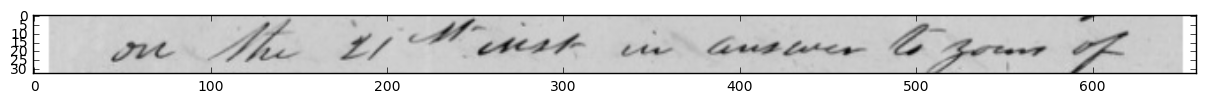

In [14]:
plt.imshow(chunk, cmap="gray")
plt.show()

In [16]:
chunk.dot(np.array([0,1]))

ValueError: shapes (33,659) and (2,) not aligned: 659 (dim 1) != 2 (dim 0)

In [ ]:
# choose which smoothing factor to use based on minimizing
# the white space
extents = []
count = 0
for j in range(len(sigYs)):
    filt = gf(input=chunk, sigma=(sigYs[j],sigXs[j]), order=0)
    if count < 2:
        th = filters.threshold_otsu(filt)
        count += 1
    binfilt = binarizeImg(filt, th)
    extents.append(np.sum(binfilt))
j = np.argmin(extents)

filt = ndimage.filters.gaussian_filter(input=chunk, sigma=(sigYs[j],sigXs[j]))
binfilt = 1 - binarizeImg(filt, th)

# find connect components
labels, nrObj = ndimage.label(binfilt)
osli = ndimage.find_objects(labels)

In [ ]:
# find the word boxes
rec = []
bounds = []
sh = np.max(labels.shape)
for sl in osli:
    sl0 = sl[0].indices(sh)
    sl1 = sl[1].indices(sh)

    xLeng = sl1[1]-sl1[0]
    yLeng = sl0[1]-sl0[0]
    if xLeng*yLeng > 100:
        bounds.append([sl1[0], sl1[1]])
        rec.append([[sl1[0], sl0[0]], xLeng, yLeng])

# combine those that are surrounded by others
bounds = sorted(bounds)

In [ ]:
bounds

In [ ]:
newbounds = []
skipnext = False
bPrev = bounds[0]
for i in range(1, len(bounds)):
    bCur = bounds[i]
    if bPrev[1] > bCur[0]:
        bPrev = [bPrev[0], bCur[1]]
    else:
        newbounds.append(bPrev)
        bPrev = [x for x in bCur]
newbounds.append(bPrev)

In [ ]:
newbounds

In [ ]:
wbLine = [0]
for i in range(1, len(newbounds)):
    b1 = newbounds[i-1]
    b2 = newbounds[i]
    wbLine.append(np.mean([b1[1], b2[0]])-fix)
wbLine.append(b2[1])
wbLine.append(chunk.shape[1])

# plot connected components
if plotIt:
    fit,ax = plt.subplots(1)
    ax.imshow(labels, cmap='nipy_spectral')
    for i in range(len(rec)):
        rect = mpl.patches.Rectangle(rec[i][0], rec[i][1], rec[i][2], linewidth=1, edgecolor="r", facecolor="none")
        ax.add_patch(rect)
    plt.show()

# return np.array(wbLine).astype("int")

## Testing out gaussian approach

In [ ]:
# function parameters
i = 4 # pretending that we're on line i
chunk = grey[lb[i]:lb[i+1],]

nu=3.5
shear=0.6
fix=15
plotIt=False

In [ ]:
# get smoothing factors
sigYs = np.arange(1, 8, 0.3)
sigXs = sigYs * nu
# rescale the image
oldrg = (np.max(chunk) - np.min(chunk))
newrg = 2
ch2 = (((chunk - np.min(chunk)) * newrg) / oldrg) - 1
# shear the image
mytf = tf.AffineTransform(shear=shear)
chunk = tf.warp(ch2, inverse_map=mytf)

# choose which smoothing factor to use based on minimizing
# the white space
extents = []
count = 0
for j in range(len(sigYs)):
    filt = gf(input=chunk, sigma=(sigYs[j],sigXs[j]), order=0)
    if count < 2:
        th = filters.threshold_otsu(filt)
        count += 1
    binfilt = binarizeImg(filt, th)
    extents.append(np.sum(binfilt))
j = np.argmin(extents)

filt = ndimage.filters.gaussian_filter(input=chunk, sigma=(sigYs[j],sigXs[j]))
binfilt = 1 - binarizeImg(filt, th)

# find connect components
labels, nrObj = ndimage.label(binfilt)
osli = ndimage.find_objects(labels)

# find the word boxes
rec = []
bounds = []
sh = np.max(labels.shape)
for sl in osli:
    sl0 = sl[0].indices(sh)
    sl1 = sl[1].indices(sh)

    xLeng = sl1[1]-sl1[0]
    yLeng = sl0[1]-sl0[0]
    if xLeng*yLeng > 100:
        bounds.append([sl1[0], sl1[1]])
        rec.append([[sl1[0], sl0[0]], xLeng, yLeng])
# combine those that are surrounded by others
bounds = sorted(bounds)
newbounds = []
bPrev = bounds[0]
for i in range(1, len(bounds)):
    bCur = bounds[i]
    if bPrev[1] > bCur[0]:
        bPrev = [bPrev[0], bCur[1]]
    else:
        newbounds.append(bPrev)
        bPrev = bCur
newbounds.append(bPrev)
wbLine = [0]
for i in range(1, len(newbounds)):
    b1 = newbounds[i-1]
    b2 = newbounds[i]
    wbLine.append(np.mean([b1[1], b2[0]])-fix)
wbLine.append(chunk.shape[1])

# plot connected components
if plotIt:
    fit,ax = plt.subplots(1)
    ax.imshow(labels, cmap='nipy_spectral')
    for i in range(len(rec)):
        rect = mpl.patches.Rectangle(rec[i][0], rec[i][1], rec[i][2], linewidth=1, edgecolor="r", facecolor="none")
        ax.add_patch(rect)
    plt.show()

# return np.array(wbLine).astype("int")